In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Dense, Input, Flatten, Conv2D,Conv1D, MaxPooling2D,MaxPooling1D,GlobalMaxPooling1D,GlobalMaxPooling2D
from keras.layers import Reshape, Dropout, Concatenate, LSTM,Bidirectional,BatchNormalization
from keras.layers import Flatten,Activation,CuDNNGRU,CuDNNLSTM,LeakyReLU
from keras.models import Model
from keras.models import Sequential
from keras import regularizers,optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score
import os
import json
from IPython.core.display import display, HTML
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


Using TensorFlow backend.


In [0]:
PAD_ROWS=26
PAD_COLS=500

In [4]:
print(os.listdir('drive/My Drive/DL Dataset'))
dir = 'drive/My Drive/DL Dataset/'
f = open(os.path.join(dir, 'train.json'), encoding="utf8")
data = json.load(f)

['dev.json', 'train.json', 'valence_1000.h5', 'model_cnn.h5']


In [31]:
df = pd.DataFrame(data)
df= df.T
TOTAL_DATA=df.shape[0]
df['labels'] = df[['valence', 'activation']].values.tolist()
df.head()

,valence,activation,features,labels
0,0,1,"[[5.502810676891276, 5.389630715979907, 5.8907...","[0, 1]"
1,1,1,"[[5.059076172970736, 5.288492317702101, 4.2633...","[1, 1]"
2,0,1,"[[4.218546271669202, 4.961436495859291, 3.6650...","[0, 1]"
3,1,0,"[[4.650364321573866, 4.523905028353254, 5.0168...","[1, 0]"
4,0,1,"[[3.900221957277269, 2.7325726489808124, 2.565...","[0, 1]"


In [32]:
sizes=np.array([])
for index, row in tqdm_notebook(df.iterrows()):
  sizes = np.append(sizes,np.array(row['features']).shape[0])

#Sort according to size to minimize padding
df['size']=sizes
# df=df.sort_values('size')
df.tail()

,valence,activation,features,labels,size
7795,0,1,"[[5.831977880602283, 7.114089905559089, 8.5546...","[0, 1]",373.0
7796,1,1,"[[0.5258330439623891, 2.9272643183639397, 3.84...","[1, 1]",292.0
7797,0,1,"[[4.143303134724048, 3.7911807963903073, 4.709...","[0, 1]",128.0
7798,0,1,"[[5.172589067838509, 3.7146765808185527, 3.819...","[0, 1]",73.0
7799,1,1,"[[2.9948686455027067, 5.909227387778969, 6.208...","[1, 1]",134.0


(array([6.675e+03, 9.920e+02, 1.190e+02, 1.000e+01, 4.000e+00]),
 array([  30. ,  365.4,  700.8, 1036.2, 1371.6, 1707. ]),
 <a list of 5 Patch objects>)

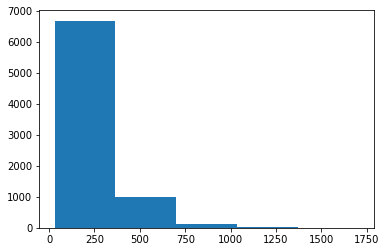

In [33]:
import matplotlib.pyplot as plt
plt.hist(sizes, bins=5)
#np.histogram(sizes,bins=10)

In [57]:
# For input to CNN : Shape: (N x 26)
feat = np.zeros((TOTAL_DATA,PAD_COLS, PAD_ROWS),dtype=np.float32)
feature_set=pd.DataFrame(np.zeros((TOTAL_DATA,2),dtype=np.float32),columns=['features','label'])
feature_set['features']=df['features']
code=0
split_index = int(TOTAL_DATA*0.9)
scaler = MinMaxScaler()

# Use only 800 features to learn, cropping the rest
for i in tqdm_notebook(range(TOTAL_DATA)):
    x = np.array(df['features'][i])[:PAD_COLS,:]
    [r,c] = x.shape
    feat[i,:r,:c] = scaler.fit_transform(x)   # Scale to [0,1] range
    feature_set['features'][i] = feat[i]
    v = df['valence'][i]
    a = df['activation'][i]
    
    if v==0 and a==0:
        code=0
    elif v==0 and a==1:
        code=1
    elif v==1 and a==0:
        code=2
    elif v==1 and a==1:
        code=3
    feature_set['label'][i]=code
print(feat.shape)


(7800, 500, 26)


In [0]:
labels=feature_set['label'].astype(int)
labels = pd.get_dummies(feature_set['label']).values.tolist()
X = feat
Y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=96)
input_dim=X[0].shape

In [59]:
input_dim

(500, 26)

In [0]:
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=9, padding='same',input_shape=input_dim,name='Conv1'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(Conv1D(filters=256, kernel_size=6, padding='same',name='Conv2'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, padding='same',name='Conv3'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

model.fit(X_train, y_train, verbose=1, epochs=200, validation_data=(X_test, y_test), shuffle=True)  # train the model
#model.fit(X, Y, verbose=1, epochs=200, validation_data=(X_test, y_test), shuffle=True)  # train the model, verbose=1, epochs=100, shuffle=True)  # train the model

Train on 7410 samples, validate on 390 samples
Epoch 1/200
7410/7410 [==============================] - 7s 1ms/step - loss: 1.6957 - categorical_accuracy: 0.3617 - val_loss: 1.3319 - val_categorical_accuracy: 0.3000
Epoch 2/200
7410/7410 [==============================] - 5s 645us/step - loss: 1.3450 - categorical_accuracy: 0.3942 - val_loss: 1.3389 - val_categorical_accuracy: 0.3077
Epoch 3/200
7410/7410 [==============================] - 5s 643us/step - loss: 1.2748 - categorical_accuracy: 0.4117 - val_loss: 1.2904 - val_categorical_accuracy: 0.4436
Epoch 4/200
7410/7410 [==============================] - 5s 643us/step - loss: 1.2672 - categorical_accuracy: 0.4204 - val_loss: 1.2585 - val_categorical_accuracy: 0.4487
Epoch 5/200
7410/7410 [==============================] - 5s 646us/step - loss: 1.2580 - categorical_accuracy: 0.4201 - val_loss: 1.3550 - val_categorical_accuracy: 0.3410
Epoch 6/200
7410/7410 [==============================] - 5s 649us/step - loss: 1.2302 - categorical_

In [0]:
#Saving a model Syntax:
#model.save("drive/My Drive/DL Dataset/model_cnn.h5")

In [0]:
f = open(os.path.join(dir, 'dev.json'), encoding="utf8")
dev = json.load(f)

In [19]:
df = pd.DataFrame(dev)
df= df.T
TOTAL_DATA=df.shape[0]
tst = np.zeros((TOTAL_DATA,PAD_COLS, PAD_ROWS),dtype=np.float32)
scaler = MinMaxScaler()


for i in tqdm_notebook(range(TOTAL_DATA)):
    x = np.array(df['features'][i])[:PAD_COLS,:]
    [r,c] = x.shape
    tst[i,:r,:c] = scaler.fit_transform(x)   # Scale to [0,1] range
    
print(tst.shape)


(3342, 600, 26)


In [0]:
pred = model.predict(tst)
y_label=np.argmax(y_test, axis=1)
pred=np.argmax(pred, axis=1)

In [23]:
res=pd.DataFrame(np.zeros((TOTAL_DATA,2),dtype=np.int),columns=['valence','activation'])

## Prepare output file : Decipher predicted code to valence and activation values
for i in tqdm_notebook(range(TOTAL_DATA)):
    
    x=pred[i]
    if x==0:        
       v=0
       a=0
    elif x==1:
        v=0
        a=1
    elif x==2:
        v=1
        a=0
    elif x==3:
        v=1
        a=1
    res['valence'][i] = v
    res['activation'][i] = a

In [0]:
res.to_json('drive/My Drive/DL Dataset/res1.json',orient='index')